#Explainer File

In [ ]:
!gdown 1R1QoK81AGOJ37rXiiuwzteMFOAHl7Vkj

Downloading...
From: https://drive.google.com/uc?id=1R1QoK81AGOJ37rXiiuwzteMFOAHl7Vkj
To: /content/transfer_train_explainer.md
100% 2.23k/2.23k [00:00<00:00, 11.6MB/s]


#Import Libraries and Data

## Libraries

In [ ]:
%%capture
import kagglehub
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
!pip install ipython-autotime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from collections import Counter
from tensorflow.keras import layers, models, regularizers
%load_ext autotime

time: 368 µs (started: 2025-04-16 06:23:49 +00:00)


##data

In [ ]:
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset
!mv /kaggle/input/stanford-cars-dataset/* /content/dataset

Streaming output truncated to the last 5000 lines.
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/05728.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/05599.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/01116.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/03807.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/04438.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/07455.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/06060.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/06052.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_t

In [ ]:
!gdown 1DuxsPDp4Dz-iBYZXj6xbL0f6iU9ZbIa2 -O stanford_cars_with_class_names_training.csv
!gdown 1lD1pcg7ddqo-qxGZhW6XKYJAwAbuzuPE -O stanford_cars_with_class_names_test.csv

Downloading...
From: https://drive.google.com/uc?id=1DuxsPDp4Dz-iBYZXj6xbL0f6iU9ZbIa2
To: /content/stanford_cars_with_class_names_training.csv
100% 502k/502k [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lD1pcg7ddqo-qxGZhW6XKYJAwAbuzuPE
To: /content/stanford_cars_with_class_names_test.csv
100% 472k/472k [00:00<00:00, 57.7MB/s]
time: 8.13 s (started: 2025-04-16 06:26:54 +00:00)


Load CSV files content

In [ ]:
import pandas as pd

def load_and_inspect_csv(file_path):
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df.columns = df.columns.str.strip()
        df.rename(columns={'ture_class_name': 'true_class_name'}, inplace=True)

        print("CSV Data Preview:")
        print(df.head())

        print("\nColumn Names:", df.columns)
        print("\nData Info:")
        print(df.info())

        return df
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return None

csv_train_file_path = '/content/stanford_cars_with_class_names_training.csv'
csv_test_file_path = '/content/stanford_cars_with_class_names_test.csv'

data_cleaned_train = load_and_inspect_csv(csv_train_file_path)
data_cleaned_test = load_and_inspect_csv(csv_test_file_path)
data_cleaned_test["image"] = data_cleaned_test["image"].str.strip().str.replace("'", "")



CSV Data Preview:
   Unnamed: 0   x1   y1    x2    y2  class  \
0           0   39  116   569   375     14   
1           1   36  116   868   587      3   
2           2   85  109   601   381     91   
3           3  621  393  1484  1096    134   
4           4   14   36   133    99    106   

                       true_class_name      image  
0                  Audi TTS Coupe 2012  00001.jpg  
1                  Acura TL Sedan 2012  00002.jpg  
2           Dodge Dakota Club Cab 2007  00003.jpg  
3     Hyundai Sonata Hybrid Sedan 2012  00004.jpg  
4  Ford F-450 Super Duty Crew Cab 2012  00005.jpg  

Column Names: Index(['Unnamed: 0', 'x1', 'y1', 'x2', 'y2', 'class', 'true_class_name',
       'image'],
      dtype='object')

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       8144 non-null   int64 
 1   x1      

# Data Processing

##Preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
csv_train = "/content/stanford_cars_with_class_names_training.csv"
csv_test = "/content/stanford_cars_with_class_names_test.csv"

dir_train = "/content/dataset/cars_train/cars_train"
dir_test = "/content/dataset/cars_test/cars_test"

save_img_path = "/content/all_images.npy"
save_label_path = "/content/all_labels.npy"

df_train = pd.read_csv(csv_train, encoding="utf-8-sig")
df_test = pd.read_csv(csv_test, encoding="utf-8-sig")

for df in [df_train, df_test]:
    df.columns = df.columns.str.strip()
    df["image"] = df["image"].str.strip().str.replace("'", "")
    df.rename(columns={"ture_class_name": "true_class_name"}, inplace=True)
    df["class"] = df["class"] - 1

df_train["path"] = df_train["image"].apply(lambda x: os.path.join(dir_train, x))
df_test["path"] = df_test["image"].apply(lambda x: os.path.join(dir_test, x))

df_all = pd.concat([df_train, df_test], ignore_index=True)

resize_to = (224,224)

images = np.zeros((len(df_all), resize_to[1], resize_to[0], 3), dtype=np.uint8)
labels = np.zeros(len(df_all), dtype=np.int32)

for i, row in tqdm(df_all.iterrows(), total=len(df_all)):
    try:
        with Image.open(row["path"]) as img:
            x1, y1, x2, y2 = map(int, [row["x1"], row["y1"], row["x2"], row["y2"]])
            cropped = img.crop((x1, y1, x2, y2)).convert("RGB")

            img_tensor = tf.convert_to_tensor(np.array(cropped), dtype=tf.uint8)
            padded_resized = tf.image.resize_with_pad(img_tensor, target_height=resize_to[1], target_width=resize_to[0])
            padded_resized = tf.cast(padded_resized, tf.uint8).numpy()

            images[i] = padded_resized
            labels[i] = row["class"]
    except Exception as e:
        print(f"Error processing {row['path']}: {e}")

np.save(save_img_path, images)
np.save(save_label_path, labels)

print(f"✅ Saved all images: {save_img_path}, shape: {images.shape}")
print(f"✅ Saved all labels: {save_label_path}, shape: {labels.shape}")


100%|██████████| 16185/16185 [03:21<00:00, 80.42it/s]


✅ Saved all images: /content/all_images.npy, shape: (16185, 224, 224, 3)
✅ Saved all labels: /content/all_labels.npy, shape: (16185,)
time: 3min 26s (started: 2025-04-16 06:27:03 +00:00)


##Data Split

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

images = np.load(save_img_path)
labels = np.load(save_label_path)

images = images.astype("float32") / 255.0
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=196)

X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
print(f"✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


##Labels For Test

In [ ]:
y_test_int = np.argmax(y_test, axis=1) + 1
y_train_int = np.argmax(y_train, axis=1) + 1

##Data Augmentations

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.central_crop(image, central_fraction=tf.random.uniform([], 0.8, 1.0))

    zoom_factor = tf.random.uniform([], 0.9, 1.0)
    new_size = tf.cast(zoom_factor * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
    image = tf.image.resize_with_crop_or_pad(image, new_size[0], new_size[1])
    image = tf.image.resize(image, [224, 224])

    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

def build_dataset(X, y, batch_size=32, shuffle=True, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(1000)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = build_dataset(X_train, y_train, augment_data=True)
val_dataset = build_dataset(X_test, y_test, shuffle=False, augment_data=False)


In [ ]:
#def augment(image, label):
#    image = tf.image.random_flip_left_right(image)
#    image = tf.image.random_brightness(image, max_delta=0.2)
#    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
#    image = tf.image.random_hue(image, max_delta=0.1)
#    image = tf.image.central_crop(image, central_fraction=tf.random.uniform([], 0.8, 1.0))
#    image = tf.image.resize(image, [224,224])
#    image = tf.clip_by_value(image, 0.0, 1.0)
#    return image, label
#
#def build_dataset(X, y, batch_size=32, shuffle=True, augment_data=False):
#    ds = tf.data.Dataset.from_tensor_slices((X, y))
#    if shuffle:
#        ds = ds.shuffle(1000)
#    if augment_data:
#        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
#    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
#    return ds
#
#train_dataset = build_dataset(X_train, y_train, augment_data=True)
#val_dataset = build_dataset(X_test, y_test, shuffle=False, augment_data=False)
#

time: 242 µs (started: 2025-04-16 06:30:52 +00:00)


# Experiment number 1

##Architecture

In [ ]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def build_transfer_model(input_shape=(224, 224, 3), num_classes=196, dropout_rate=0.3):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_transfer_model(num_classes=196)

print("✅ Model Summary:")
model.summary()

print("\n✅ Layer Details:")
for i, layer in enumerate(model.layers):
    try:
        print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}, Output Shape: {layer.output.shape}")
    except:
        print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}, Output Shape: N/A")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │        50,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,427,879 (16.89 MB)

 Trainable params: 378,308 (1.44 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


✅ Layer Details:
Layer 0: efficientnetb0, Trainable: False, Output Shape: (None, 7, 7, 1280)
Layer 1: global_average_pooling2d, Trainable: True, Output Shape: (None, 1280)
Layer 2: dropout, Trainable: True, Output Shape: (None, 1280)
Layer 3: dense, Trainable: True, Output Shape: (None, 256)
Layer 4: dropout_1, Trainable: True, Output Shape: (None, 256)
Layer 5: dense_1, Trainable: True, Output Shape: (None, 196)
time: 4.24 s (started: 2025-04-14 12:55:58 +00:00)


##Train

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 87s 119ms/step - accuracy: 0.0056 - loss: 5.3012 - val_accuracy: 0.0074 - val_loss: 5.2785
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0079 - loss: 5.2762 - val_accuracy: 0.0074 - val_loss: 5.2792
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0072 - loss: 5.2757 - val_accuracy: 0.0074 - val_loss: 5.2801
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0077 - loss: 5.2738 - val_accuracy: 0.0074 - val_loss: 5.2809
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
time: 1min 49s (started: 2025-04-14 12:56:02 +00:00)


##Loss Graph

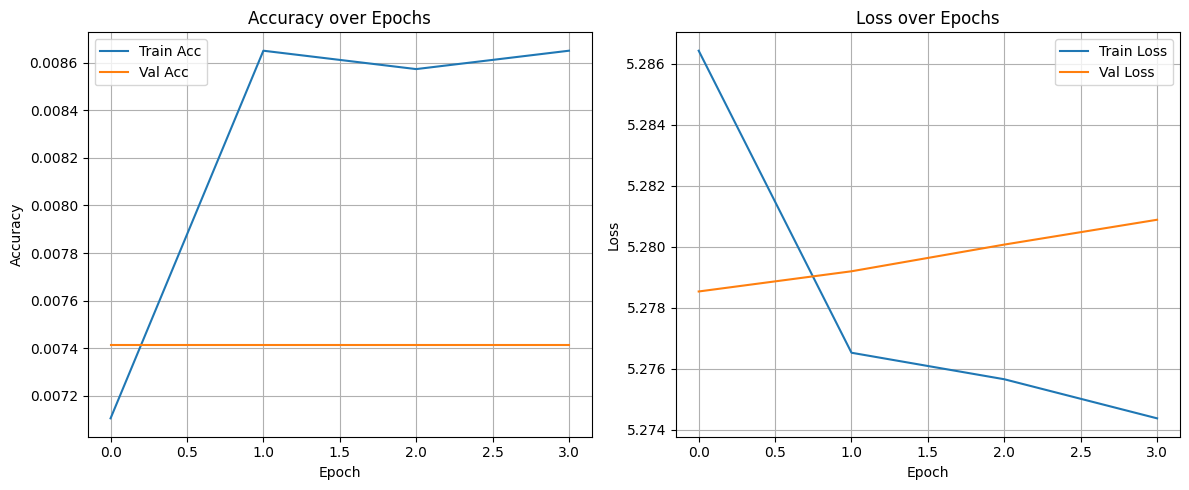

time: 368 ms (started: 2025-04-14 12:57:51 +00:00)


In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


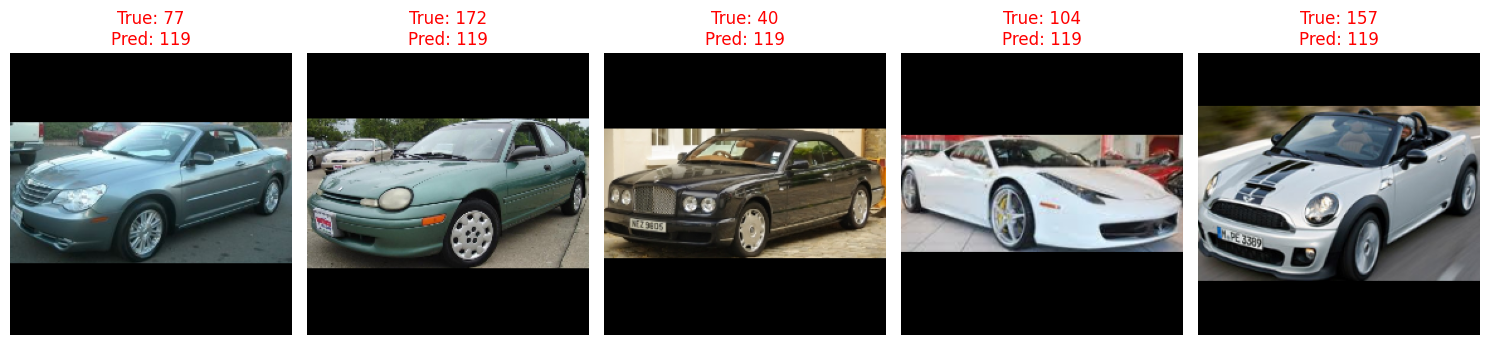

time: 7.12 s (started: 2025-04-14 12:57:52 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(X_test), size=5, replace=False)
sample_images = X_test[random_indices]
true_labels = y_test_int[random_indices]

pred_probs = model.predict(sample_images)
pred_labels = np.argmax(pred_probs, axis=1) + 1

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    title_color = "green" if pred_labels[i] == true_labels[i] else "red"
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}", color=title_color)

plt.tight_layout()
plt.show()


# Experiment number 2

##Architecture

In [ ]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def build_finetuned_model(input_shape=(224, 224, 3), num_classes=196, dropout_rate=0.3, unfreeze_from=150):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:unfreeze_from]:
        layer.trainable = False
    for layer in base_model.layers[unfreeze_from:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model2 = build_finetuned_model(num_classes=196)

print("🔧 Fine-tuned Model Summary:")
model2.summary()


🔧 Fine-tuned Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 196)            │        50,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,427,879 (16.89 MB)

 Trainable params: 3,666,012 (13.98 MB)

 Non-trainable params: 761,867 (2.91 MB)

time: 1.11 s (started: 2025-04-14 12:57:59 +00:00)


##Train

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

early_stop2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stop2],
    verbose=1
)


Epoch 1/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 92s 113ms/step - accuracy: 0.0046 - loss: 5.3232 - val_accuracy: 0.0056 - val_loss: 5.2790
Epoch 2/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.0077 - loss: 5.2780 - val_accuracy: 0.0040 - val_loss: 5.2803
Epoch 3/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.0086 - loss: 5.2765 - val_accuracy: 0.0074 - val_loss: 5.2797
Epoch 4/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.0078 - loss: 5.2745 - val_accuracy: 0.0074 - val_loss: 5.2805
Epoch 5/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.0079 - loss: 5.2735 - val_accuracy: 0.0074 - val_loss: 5.2814
Epoch 6/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.0076 - loss: 5.2736 - val_accuracy: 0.0074 - val_loss: 5.2822
Epoch 7/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.0074 - loss: 5.2727 - val_accuracy: 0.0074 - val_loss: 5.2830
Epoch 8/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.0077 - loss: 

##Loss Graph

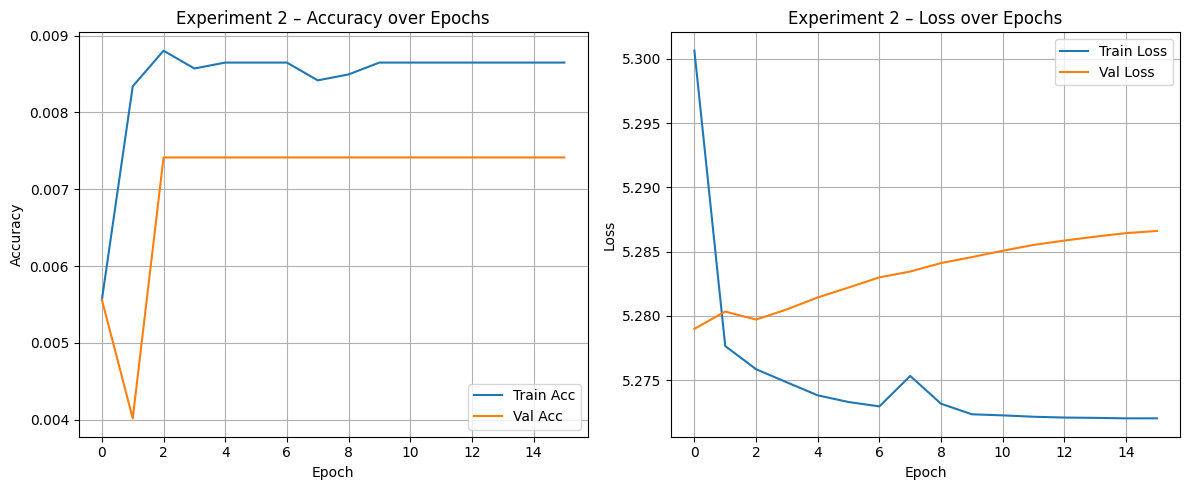

time: 329 ms (started: 2025-04-14 13:02:03 +00:00)


In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Experiment 2 – Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Experiment 2 – Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


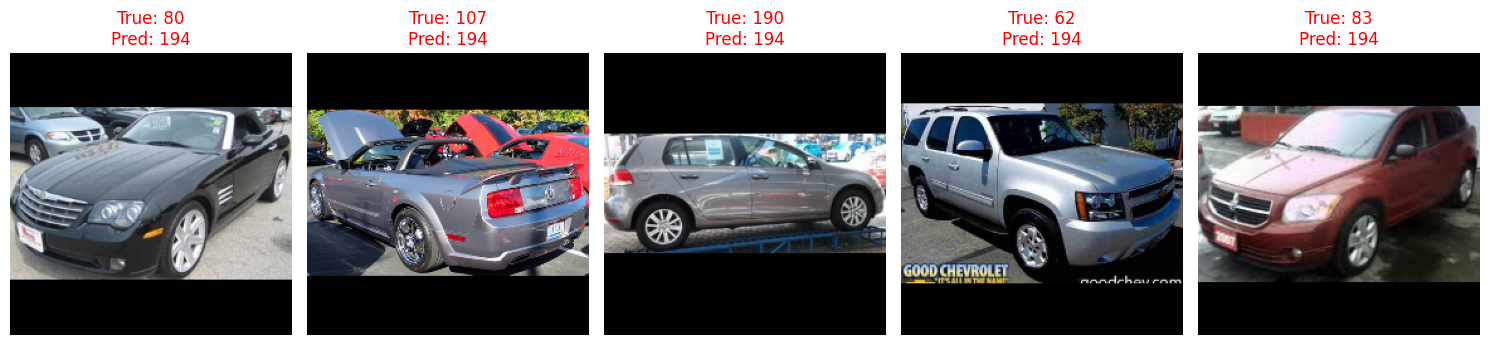

time: 7.59 s (started: 2025-04-14 13:02:03 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(X_test), size=5, replace=False)
sample_images = X_test[random_indices]
true_labels = y_test_int[random_indices]

pred_probs = model2.predict(sample_images)
pred_labels = np.argmax(pred_probs, axis=1) + 1
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    title_color = "green" if pred_labels[i] == true_labels[i] else "red"
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}", color=title_color)

plt.tight_layout()
plt.show()


#Experiment number 3

##Architecture

In [ ]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def build_finetuned_model(input_shape=(224, 224, 3), num_classes=196, dropout_rate=0.3, unfreeze_from=20):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:unfreeze_from]:
        layer.trainable = False
    for layer in base_model.layers[unfreeze_from:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model3 = build_finetuned_model(num_classes=196)

print("🔧 Fine-tuned Model Summary:")
model3.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔧 Fine-tuned Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │        50,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,427,879 (16.89 MB)

 Trainable params: 4,381,752 (16.72 MB)

 Non-trainable params: 46,127 (180.19 KB)

time: 2.13 s (started: 2025-04-16 06:39:36 +00:00)


##Train

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

early_stop3 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history3 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[early_stop3],
    verbose=1
)


Epoch 1/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 167s 195ms/step - accuracy: 0.0038 - loss: 5.3572 - val_accuracy: 0.0080 - val_loss: 5.2957
Epoch 2/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0042 - loss: 5.3143 - val_accuracy: 0.0062 - val_loss: 5.2793
Epoch 3/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0070 - loss: 5.2931 - val_accuracy: 0.0068 - val_loss: 5.2602
Epoch 4/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0074 - loss: 5.2771 - val_accuracy: 0.0096 - val_loss: 5.2461
Epoch 5/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0086 - loss: 5.2565 - val_accuracy: 0.0099 - val_loss: 5.2340
Epoch 6/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0101 - loss: 5.2469 - val_accuracy: 0.0158 - val_loss: 5.2228
Epoch 7/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0132 - loss: 5.2306 - val_accuracy: 0.0182 - val_loss: 5.2026
Epoch 8/200
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0147 - loss:

##Loss Graph

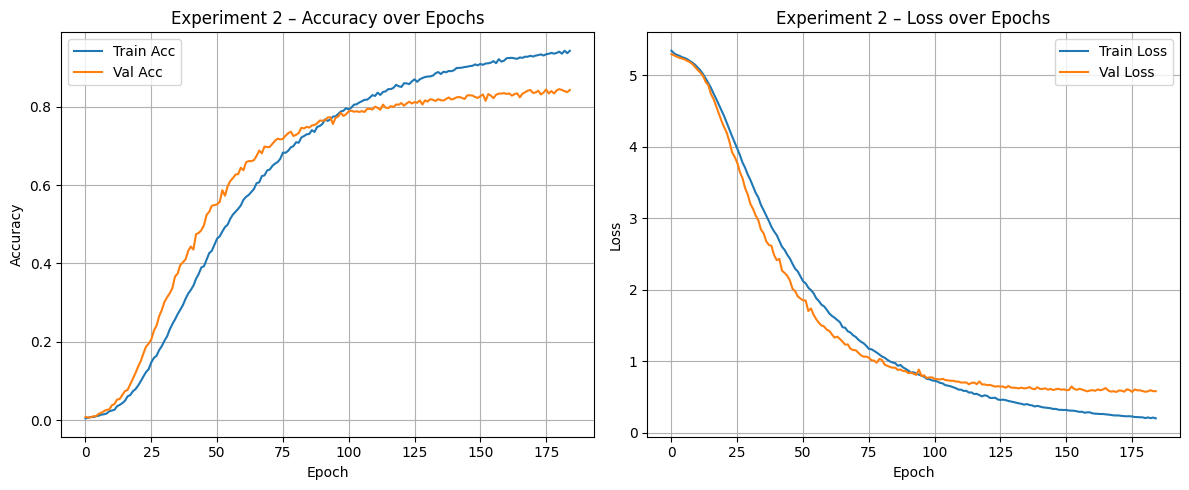

time: 325 ms (started: 2025-04-16 07:25:47 +00:00)


In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Acc')
plt.plot(history3.history['val_accuracy'], label='Val Acc')
plt.title("Experiment 2 – Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title("Experiment 2 – Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


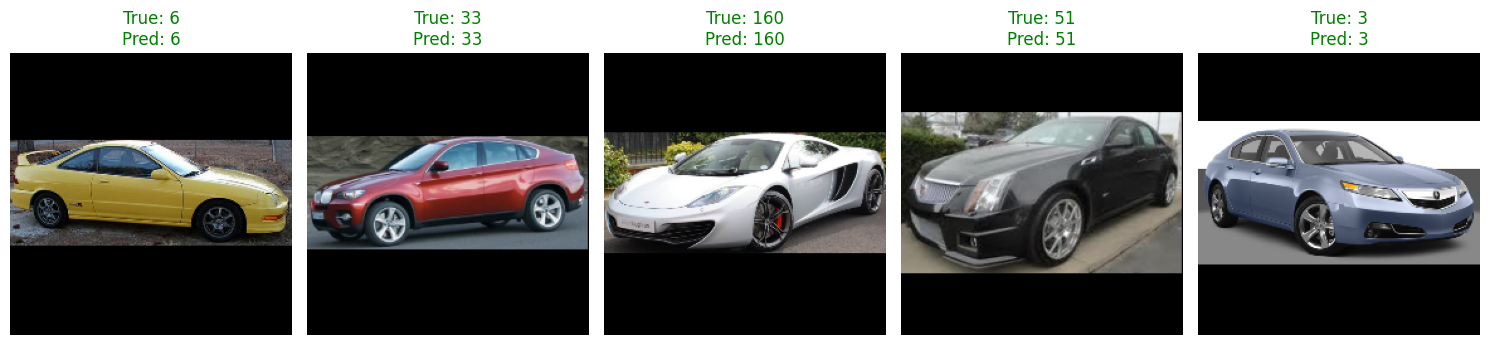

time: 6.83 s (started: 2025-04-16 07:25:47 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(X_test), size=5, replace=False)
sample_images = X_test[random_indices]
true_labels = y_test_int[random_indices]

pred_probs = model3.predict(sample_images)
pred_labels = np.argmax(pred_probs, axis=1) + 1

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    title_color = "green" if pred_labels[i] == true_labels[i] else "red"
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}", color=title_color)

plt.tight_layout()
plt.show()


#Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
model3.save('/content/drive/MyDrive/efficientnet_finetuned.keras')

Mounted at /content/drive
time: 23.9 s (started: 2025-04-16 07:27:39 +00:00)
